# Model Implementation

**Security DS - Proyecto 1**

Roberto Figueroa - 18306

Gustavo Méndez - 18500

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import reduce_memory_usage
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn import metrics, model_selection, tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, plot_confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.compose import ColumnTransformer
from itertools import cycle


%matplotlib inline
pd.set_option("display.max_columns", None)

In [2]:
chunk_samples = []
CHUNK_SIZE = 10 ** 6

for chunk in pd.read_csv('./datasets/preprocessed_dataset.csv.zip', index_col=[0], chunksize=CHUNK_SIZE):
    reduced_chunk = reduce_memory_usage(chunk, verbose=False)
    chunk_samples.append(reduced_chunk)
    
df = pd.concat(chunk_samples, ignore_index=True)
del chunk_samples

This is how our preprocessed dataset views like

In [3]:
df.head()

,FIRST_SWITCHED,FLOW_DURATION_MICROSECONDS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,TCP_WIN_MIN_IN,TCP_WIN_MIN_OUT,TCP_WIN_MSS_IN,TCP_WIN_SCALE_OUT,TCP_WIN_SCALE_IN,TOTAL_FLOWS_EXP,tcp,udp,SRC_PKT_PRECEDENCE,DST_PKT_PRECEDENCE,URG,ACK,PSH,RST,SYN,FIN,LABEL
0,1618194298,-0.821289,-0.116516,0.700684,1618194298,-0.800293,-0.744141,-0.804688,-0.743652,-1.385742,-0.768555,-0.816895,0.512207,1,0,5,5,0,0,0,1,1,0,2
1,1618185270,-0.822754,-0.014404,0.324707,1618185270,-0.838867,-0.744141,-0.837402,-0.743652,-1.385742,-0.768555,-0.816895,0.503906,0,1,0,0,0,1,0,0,0,1,2
2,1618225083,-0.822754,-0.570801,-1.906250,1618225083,-0.838867,-0.744141,-0.837402,-0.743652,-1.385742,-0.768555,-0.816895,0.582031,0,1,0,0,0,1,0,0,0,1,2
3,1618219151,-0.817871,-0.309570,0.797363,1618219152,-0.800293,-0.744141,-0.804688,-0.743652,-1.385742,-0.768555,-0.816895,0.559082,1,0,1,0,0,0,0,1,1,0,2
4,1618197175,-0.811523,-0.576660,-2.744141,1618197176,-0.838867,-0.744141,-0.837402,-0.743652,-1.385742,-0.768555,-0.816895,0.515137,0,0,6,0,0,0,0,0,0,1,2


In [4]:
df.shape

(9107788, 24)

### Split data

In [5]:
y = df['LABEL']
X = df.drop('LABEL', axis=1, inplace=False)

target_names = ['DDos RUDY', 'DDos Slowloris', 'Normal Flow', 'SYN-Scan']

In [6]:
X_train, X_test_total, y_train, y_test_total = train_test_split(X, y, train_size=0.55, random_state=42)

In [7]:
X_test, X_val, y_test, y_val = train_test_split(X_test_total, y_test_total, test_size=0.33, random_state=97)

In [8]:
X_train.head()

,FIRST_SWITCHED,FLOW_DURATION_MICROSECONDS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,TCP_WIN_MIN_IN,TCP_WIN_MIN_OUT,TCP_WIN_MSS_IN,TCP_WIN_SCALE_OUT,TCP_WIN_SCALE_IN,TOTAL_FLOWS_EXP,tcp,udp,SRC_PKT_PRECEDENCE,DST_PKT_PRECEDENCE,URG,ACK,PSH,RST,SYN,FIN
8191873,1618229523,-0.822266,-0.572266,0.762207,1618229523,1.240234,1.141602,1.241211,1.143555,0.684570,1.305664,1.201172,0.622559,1,0,0,0,0,0,0,1,1,0
8642854,1618231372,1.777344,-0.572266,0.628418,1618231484,1.240234,1.141602,1.241211,1.143555,0.684570,1.305664,1.201172,0.642090,1,0,0,0,0,0,0,1,1,0
1057646,1618257844,-0.822754,1.940430,0.458252,1618257844,1.220703,-0.744141,1.221680,-0.743652,0.758301,-0.768555,1.489258,0.731934,1,0,1,0,0,0,0,1,1,0
5073047,1616663801,-0.822754,-0.073792,0.407715,1616663801,-0.806152,-0.744141,-0.804688,-0.743652,0.758301,-0.768555,-0.816895,-1.584961,1,0,0,0,0,0,0,1,1,0
7887439,1618228180,1.737305,-0.572266,-0.379883,1618228290,-0.822754,-0.736328,-0.821289,-0.735840,-1.385742,-0.768555,-0.816895,0.610840,1,0,0,0,0,0,0,1,1,0


In [9]:
y_train.head()

8191873    0
8642854    0
1057646    2
5073047    3
7887439    0
Name: LABEL, dtype: int8

In [10]:
print("Total observaciones: ", len(X))
print("Observaciones entrenamiento: ", len(X_train))
print("Observaciones de validacion: ", len(X_val))
print("Observaciones de pruebas: ", len(X_test))

Total observaciones:  9107788
Observaciones entrenamiento:  5009283
Observaciones de validacion:  1352507
Observaciones de pruebas:  2745998


## Random Forest Classifier

### Create model and train model

In [11]:
model_RF = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=4)
model_RF.fit(X_train, y_train)

RandomForestClassifier(n_jobs=4, random_state=42)

### Predict with validation data

In [12]:
val_predictions = model_RF.predict(X_val)

### Metrics

In [13]:
conf_matrix = confusion_matrix(y_val, val_predictions)
accu = accuracy_score(y_val, val_predictions)
_recall_score = recall_score(y_val, val_predictions, average='weighted')
_precision_score = precision_score(y_val, val_predictions, average='weighted')
_f1_score = f1_score(y_val, val_predictions, average='weighted')

print("\n Confusion Matrix", conf_matrix)
print("\n Accuracy", accu)
print("\n Precision", _precision_score)
print("\n Recall", _recall_score)
print("\n F1 Score", _f1_score)


 Confusion Matrix [[337866      0      1      0]
 [     0 338173      1      0]
 [     0      0 338370      3]
 [     0      0      7 338086]]

 Accuracy 0.9999911275875097

 Precision 0.9999911276792585

 Recall 0.9999911275875097

 F1 Score 0.999991127603878


In [14]:
print(metrics.classification_report(y_val, val_predictions, target_names=target_names))

                precision    recall  f1-score   support

     DDos RUDY       1.00      1.00      1.00    337867
DDos Slowloris       1.00      1.00      1.00    338174
   Normal Flow       1.00      1.00      1.00    338373
      SYN-Scan       1.00      1.00      1.00    338093

      accuracy                           1.00   1352507
     macro avg       1.00      1.00      1.00   1352507
  weighted avg       1.00      1.00      1.00   1352507



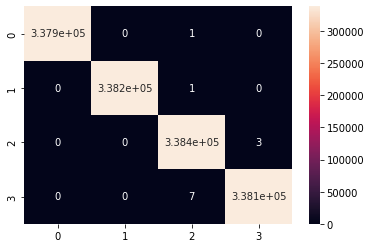

In [15]:
sns.heatmap(conf_matrix, annot=True, fmt=".4g");

### Predict with test data

In [16]:
predictions = model_RF.predict(X_test)

In [17]:
conf_matrix = confusion_matrix(y_test, predictions)
accu = accuracy_score(y_test, predictions)
_recall_score = recall_score(y_test, predictions, average='weighted')
_precision_score = precision_score(y_test, predictions, average='weighted')
_f1_score = f1_score(y_test, predictions, average='weighted')

print("\n Confusion Matrix\n", conf_matrix)
print("\n Accuracy", accu)
print("\n Precision", _precision_score)
print("\n Recall", _recall_score)
print("\n F1 Score", _f1_score)


 Confusion Matrix
 [[687356      0      1      0]
 [     0 687476      2      0]
 [     0      2 686307      9]
 [     0      0     14 684831]]

 Accuracy 0.9999898033429012

 Precision 0.999989803373094

 Recall 0.9999898033429012

 F1 Score 0.9999898033497664


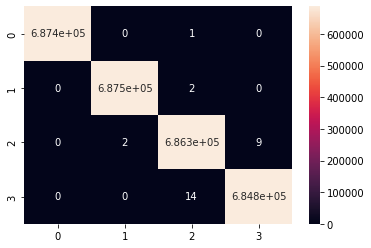

In [18]:
sns.heatmap(conf_matrix, annot=True, fmt=".4g");

### K-fold validation

In [19]:
# Validation of model after train with train data
k_folds_model_train = model_selection.KFold(n_splits=5, shuffle=True, random_state=79)
k_folds_model_train.get_n_splits(X)

5

In [20]:
scores = model_selection.cross_val_score(model_RF, X, y, cv=k_folds_model_train)
print("Scores are: ", scores)
print("Mean is: ", np.mean(scores))
print("STD is: +-", np.std(scores))

Scores are:  [0.99999726 0.99999451 0.99999286 0.99999177 0.99999122]
Mean is:  0.9999935220270759
STD is: +- 2.179392494981703e-06


### ROC Curve

In [21]:
y_ = label_binarize(y_test, classes=[0, 1, 2, 3])
pred = label_binarize(predictions, classes=[0,1,2,3])

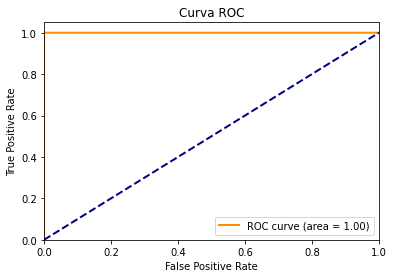

In [22]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.rcParams["figure.figsize"] = (5,5)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

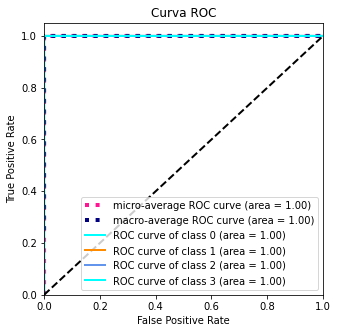

In [23]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

## Decision Tree Classifier

In [11]:
model_DT = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=3, min_samples_leaf=5)
model_DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)

### Predict with validation data

In [12]:
val_predictions = model_DT.predict(X_val)

### Metrics

In [13]:
conf_matrix = confusion_matrix(y_val, val_predictions)
accu = accuracy_score(y_val, val_predictions)
_recall_score = recall_score(y_val, val_predictions, average='weighted')
_precision_score = precision_score(y_val, val_predictions, average='weighted')
_f1_score = f1_score(y_val, val_predictions, average='weighted')

print("\n Confusion Matrix", conf_matrix)
print("\n Accuracy", accu)
print("\n Precision", _precision_score)
print("\n Recall", _recall_score)
print("\n F1 Score", _f1_score)


 Confusion Matrix [[337856      0     11      0]
 [     0 338173      1      0]
 [ 45910   4445 287800    218]
 [     3      0    307 337783]]

 Accuracy 0.9623698805255722

 Precision 0.9664316237414119

 Recall 0.9623698805255722

 F1 Score 0.9619513237619192


In [14]:
print(metrics.classification_report(y_val, val_predictions, target_names=target_names))

                precision    recall  f1-score   support

     DDos RUDY       0.88      1.00      0.94    337867
DDos Slowloris       0.99      1.00      0.99    338174
   Normal Flow       1.00      0.85      0.92    338373
      SYN-Scan       1.00      1.00      1.00    338093

      accuracy                           0.96   1352507
     macro avg       0.97      0.96      0.96   1352507
  weighted avg       0.97      0.96      0.96   1352507



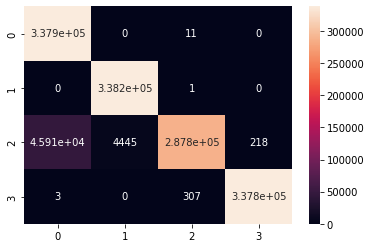

In [15]:
sns.heatmap(conf_matrix, annot=True, fmt=".4g");

### Predict with test data

In [16]:
predictions = model_DT.predict(X_test)

In [17]:
conf_matrix = confusion_matrix(y_test, predictions)
accu = accuracy_score(y_test, predictions)
_recall_score = recall_score(y_test, predictions, average='weighted')
_precision_score = precision_score(y_test, predictions, average='weighted')
_f1_score = f1_score(y_test, predictions, average='weighted')

print("\n Confusion Matrix\n", conf_matrix)
print("\n Accuracy", accu)
print("\n Precision", _precision_score)
print("\n Recall", _recall_score)
print("\n F1 Score", _f1_score)


 Confusion Matrix
 [[687327      0     30      0]
 [     0 687477      1      0]
 [ 93592   9067 583254    405]
 [     8      0    605 684232]]

 Accuracy 0.9622330387713319

 Precision 0.9663194919336353

 Recall 0.9622330387713319

 F1 Score 0.961807657354616


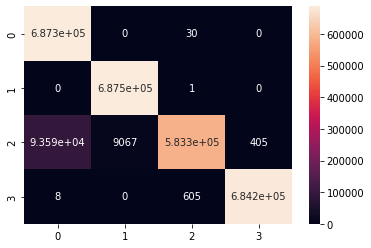

In [18]:
sns.heatmap(conf_matrix, annot=True, fmt=".4g");

### K-fold validation

In [19]:
# Validation of model after train with train data
k_folds_model_train = model_selection.KFold(n_splits=5, shuffle=True, random_state=79)
k_folds_model_train.get_n_splits(X)

5

In [20]:
scores = model_selection.cross_val_score(model_DT, X, y, cv=k_folds_model_train)
print("Scores are: ", scores)
print("Mean is: ", np.mean(scores))
print("STD is: +-", np.std(scores))

Scores are:  [0.96240855 0.96217688 0.96240636 0.96242336 0.96228611]
Mean is:  0.9623402521039095
STD is: +- 9.545863711532251e-05


### ROC Curve

In [21]:
y_ = label_binarize(y_test, classes=[0, 1, 2, 3])
pred = label_binarize(predictions, classes=[0,1,2,3])

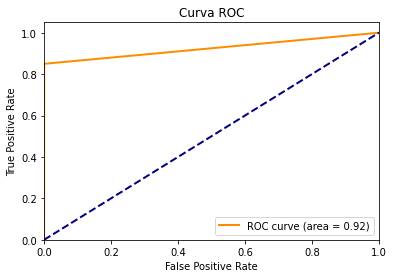

In [22]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.rcParams["figure.figsize"] = (5,5)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

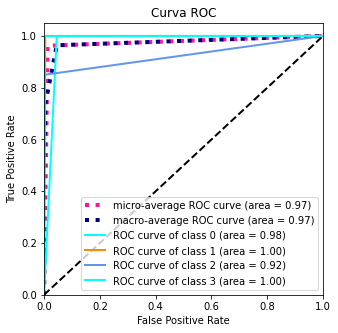

In [23]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()